##  Activation likelihood estimation
This code is largely based on the implementation provided by Enge et al. (2021), available at https://osf.io/34ry2/. We are deeply grateful for their dedication to open research.

> Enge, A., Abdel Rahman, R., & Skeide, M. A. (2021). A meta-analysis of fMRI studies of semantic cognition in children. NeuroImage, 241, 118436. https://doi.org/10.1016/j.neuroimage.2021.118436

In [3]:
# Import necessary modules
from os import makedirs, path
import numpy as np
from IPython.display import display
from nibabel import save
from nilearn import glm, image, plotting, reporting
from nimare import io, meta


## ALE analysis: Conjunction analysis

In [2]:
# Before doing the actual subtraction analyses, let's define a helper function for statistical thresholding. Since no FWE correction method has been defined for subtraction analyses (yet), we use an uncorrected voxel-level threshold (usually $p<.001$) combined with a cluster-level extent threshold (in mm<sup>3</sup>). Note that we assume the voxel size to be 2×2×2 mm<sup>3</sup> (the default in NiMARE).

# Define helper function for dual threshold based on voxel-p and cluster size (in mm3)
def dual_thresholding(
    img_z, voxel_thresh, cluster_size_mm3, two_sided=True, fname_out=None
):

    # If img_z is a file path, we first need to load the actual image
    img_z = image.load_img(img=img_z)

    # Check if the image is empty
    if np.all(img_z.get_fdata() == 0):
        print("THE IMAGE IS EMPTY! RETURNING THE ORIGINAL IMAGE.")
        return img_z

    # Convert desired cluster size to the corresponding number of voxels
    k = cluster_size_mm3 // 8

    # Actual thresholding
    img_z_thresh, thresh_z = glm.threshold_stats_img(
        stat_img=img_z,
        alpha=voxel_thresh,
        height_control="fpr",
        cluster_threshold=k,
        two_sided=two_sided,
    )

    # Print the thresholds that we've used
    print(
        "THRESHOLDING IMAGE AT Z > "
        + str(thresh_z)
        + " (P = "
        + str(voxel_thresh)
        + ") AND K > "
        + str(k)
        + " ("
        + str(cluster_size_mm3)
        + " mm3)"
    )

    # If requested, save the thresholded map
    if fname_out:
        save(img_z_thresh, filename=fname_out)

    return img_z_thresh


In [3]:
# Now we can go on to perform the actual subtraction analyses. We again define a helper function for this so we can apply this to multiple Sleuth files with a single call (and also reuse it in later notebooks). We simply read two Sleuth files into NiMARE and let its `meta.cbma.ALESubtraction()` function do the rest (as briefly described above). It outputs an unthresholded *z* score map which we then threshold using our helper function.
# Define function for performing a single ALE subtraction analysis
def run_subtraction(
    text_file1,
    text_file2,
    voxel_thresh,
    cluster_size_mm3,
    random_seed,
    n_iters,
    output_dir,
):

    # Let's show the user what we are doing
    print(
        'SUBTRACTION ANALYSIS FOR "'
        + text_file1
        + '" VS. "'
        + text_file2
        + '" WITH '
        + str(n_iters)
        + " PERMUTATIONS"
    )

    # Set a random seed to make the results reproducible
    if random_seed:
        np.random.seed(random_seed)

    # Read Sleuth files
    dset1 = io.convert_sleuth_to_dataset(text_file=text_file1)
    dset2 = io.convert_sleuth_to_dataset(text_file=text_file2)

    # Actually perform subtraction analysis
    sub = meta.cbma.ALESubtraction(n_iters=n_iters, low_memory=False)
    sres = sub.fit(dset1, dset2)

    # Save the unthresholded z map
    img_z = sres.get_map("z_desc-group1MinusGroup2")
    makedirs(output_dir, exist_ok=True)
    name1 = path.basename(text_file1).replace(".txt", "")
    name2 = path.basename(text_file2).replace(".txt", "")
    prefix = output_dir + "/" + name1 + "_minus_" + name2
    save(img_z, filename=prefix + "_z.nii.gz")

    # Create and save the thresholded z map
    dual_thresholding(
        img_z=img_z,
        voxel_thresh=voxel_thresh,
        cluster_size_mm3=cluster_size_mm3,
        two_sided=True,
        fname_out=prefix + "_z_thresh.nii.gz",
    )



## ALE analysis: Contrast analysis

In [4]:
# Define helper function for dual threshold based on voxel-p and cluster size (in mm3)
def dual_thresholding(
    img_z, voxel_thresh, cluster_size_mm3, two_sided=True, fname_out=None
):

    # If img_z is a file path, we first need to load the actual image
    img_z = image.load_img(img=img_z)

    # Check if the image is empty
    if np.all(img_z.get_fdata() == 0):
        print("THE IMAGE IS EMPTY! RETURNING THE ORIGINAL IMAGE.")
        return img_z

    # Convert desired cluster size to the corresponding number of voxels
    k = cluster_size_mm3 // 8

    # Actual thresholding
    img_z_thresh, thresh_z = glm.threshold_stats_img(
        stat_img=img_z,
        alpha=voxel_thresh,
        height_control="fpr",
        cluster_threshold=k,
        two_sided=two_sided,
    )

    # Print the thresholds that we've used
    print(
        "THRESHOLDING IMAGE AT Z > "
        + str(thresh_z)
        + " (P = "
        + str(voxel_thresh)
        + ") AND K > "
        + str(k)
        + " ("
        + str(cluster_size_mm3)
        + " mm3)"
    )

    # If requested, save the thresholded map
    if fname_out:
        save(img_z_thresh, filename=fname_out)

    return img_z_thresh

In [5]:
# Define function for performing a single ALE subtraction analysis
def run_subtraction(
    text_file1,
    text_file2,
    voxel_thresh,
    cluster_size_mm3,
    random_seed,
    n_iters,
    output_dir,
):

    # Let's show the user what we are doing
    print(
        'SUBTRACTION ANALYSIS FOR "'
        + text_file1
        + '" VS. "'
        + text_file2
        + '" WITH '
        + str(n_iters)
        + " PERMUTATIONS"
    )

    # Set a random seed to make the results reproducible
    if random_seed:
        np.random.seed(random_seed)

    # Read Sleuth files
    dset1 = io.convert_sleuth_to_dataset(text_file=text_file1)
    dset2 = io.convert_sleuth_to_dataset(text_file=text_file2)

    # Actually perform subtraction analysis
    sub = meta.cbma.ALESubtraction(n_iters=n_iters, low_memory=False)
    sres = sub.fit(dset1, dset2)

    # Save the unthresholded z map
    img_z = sres.get_map("z_desc-group1MinusGroup2")
    makedirs(output_dir, exist_ok=True)
    name1 = path.basename(text_file1).replace(".txt", "")
    name2 = path.basename(text_file2).replace(".txt", "")
    prefix = output_dir + "/" + name1 + "_minus_" + name2
    save(img_z, filename=prefix + "_z.nii.gz")

    # Create and save the thresholded z map
    dual_thresholding(
        img_z=img_z,
        voxel_thresh=voxel_thresh,
        cluster_size_mm3=cluster_size_mm3,
        two_sided=True,
        fname_out=prefix + "_z_thresh.nii.gz",
    )

In [7]:
text_file1 ="../data/ale_analysis_foci/control.txt"
text_file2 ="../data/ale_analysis_foci/patient.txt"

output_dir="../results/subtraction/"

In [ ]:
run_subtraction(
    text_file1=text_file1,
    text_file2=text_file2,
    voxel_thresh=0.001,
    cluster_size_mm3=200,
    random_seed=1234,
    n_iters=10000,
    output_dir="../results/subtraction/"
    )

In [11]:
# Compute seperate difference maps for healthy control group > patient group and patient group > healthy control group

img_sub = image.load_img(output_dir + "control_minus_patient_z_thresh.nii.gz")

img_control_gt_patients = image.math_img("np.where(img > 0, img, 0)", img=img_sub)
img_patients_gt_control = image.math_img("np.where(img < 0, img * -1, 0)", img=img_sub)
_ = save(img_control_gt_patients, output_dir + "control_greater_patients_z_thresh.nii.gz")
_ = save(img_patients_gt_control, output_dir + "patients_greater_control_z_thresh.nii.gz")

In [13]:
# Finally, we also compute a conjunction map. 
# This map shows all the brain regions that are engaged in self-referential processing in *both* groups 
# (but not those specific to either one of them).
# For these voxels, we just take the smaller of the two *z* values from both group-specific *z* score maps (Nichols et al., 2005, *NeuroImage*). 
# We then do the same for the ALE maps so we have our conjunction maps with both *z* scores and ALE values.

# Compute conjunction z map (= minimum voxel-wise z score across both groups)
formula = "np.where(img1 * img2 > 0, np.minimum(img1, img2), 0)"
img_control_z = image.load_img("../results/ale/control_all_z_thresh.nii.gz")
img_patients_z = image.load_img("../results/ale/patient_z_thresh.nii.gz")
img_conj_z = image.math_img(formula, img1=img_control_z, img2=img_patients_z)
_ = save(img_conj_z, output_dir + "control_conj_patients_z.nii.gz")


In [ ]:
# Compute conjunction ALE map (= minimum voxel-wise ALE value across both groups)
img_control_ale = image.load_img("../results/ale/control_all_stat_size_thresh.nii.gz")
img_patients_ale = image.load_img("../results/ale/control_all_stat_size_thresh.nii.gz")
img_conj_ale = image.math_img(formula, img1=img_control_ale, img2=img_patients_ale)
_ = save(img_conj_z, output_dir + "control_conj_patients_ale.nii.gz")

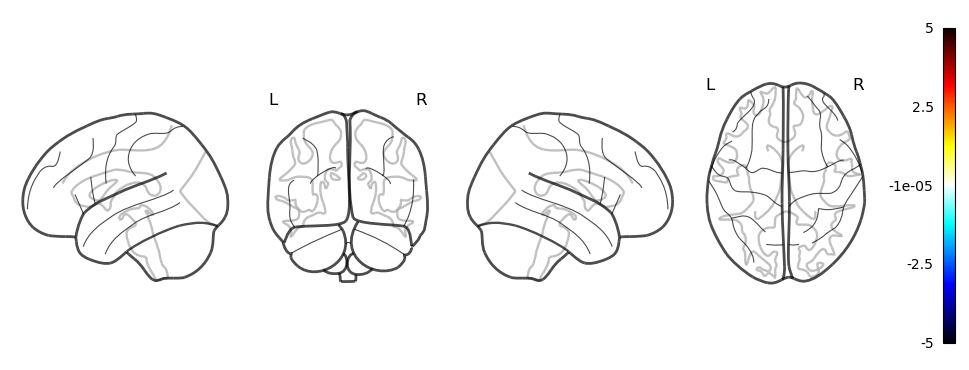

In [22]:
# Plot the subtraction map which shows us the group differences between control and patients.

# Glass brain for children vs. adults
p_sub = plotting.plot_glass_brain(
    img_sub,
    display_mode="lyrz",
    colorbar=True,
    vmax=5,
    plot_abs=False,
    symmetric_cbar=True,
)


In [ ]:
# Cluster table for control vs.patients
t_sub = reporting.get_clusters_table(
    img_sub, stat_threshold=0, min_distance=1000, two_sided=True
)
display(t_sub)


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_42376/182509850.py:2: UserWarning: Attention: No clusters with stat higher than 0
  t_sub = reporting.get_clusters_table(
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_42376/182509850.py:2: UserWarning: Attention: No clusters with stat lower than 0
  t_sub = reporting.get_clusters_table(


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


Max value: 4.30726447335323
Min value: 0.0


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-4.0,58.0,14.0,4.307264,872


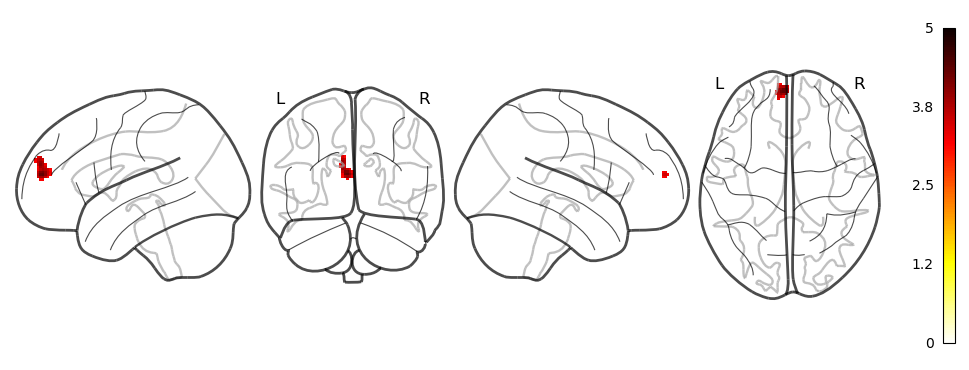

In [31]:
# And, finally, let's also plot the conjunction map to see which clusters were engaged in self-referential precessing in both control *and* patients.

img_data = nib.load(output_dir + "control_conj_patients_ale.nii.gz").get_fdata()
print("Max value:", img_data.max())
print("Min value:", img_data.min())

# Glass brain for conjunction
p_conj = plotting.plot_glass_brain(
    img_conj_z,
    display_mode="lyrz",
    colorbar=True,
    vmax=5,
    threshold=0
)

# Cluster table for conjunction
t_conj = reporting.get_clusters_table(img_conj_z, stat_threshold=0, min_distance=1000)
display(t_conj)